In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [273]:
fp = "./wine+quality/winequality-red.csv"
df_wine = pd.read_csv(fp, delimiter=";")
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**4(b): Train Test Split**

In [274]:
label = ["quality"]
features = df_wine.columns.difference(label)

In [275]:
# 60% train, 40% validation + test (20% each)
X_train, X_temp, y_train, y_temp = train_test_split(df_wine[features], df_wine[label], test_size=0.4, random_state=0)
print(len(X_train), len(X_temp))

959 640


In [276]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
print(len(X_val), len(X_test))

320 320


**4(c): LR with sum-of-squares error**

In [277]:
def concat_ones(X):
    # add 1's in front of every training sample (bias)
    return np.concatenate([np.ones(shape=(len(X), 1)), X], axis=1)

class LinearRegression:
    def __init__(self, add_bias=True):
        self.betas = None
        self.add_bias = add_bias
    
    def fit(self, X, y):
        if self.add_bias:
            X = concat_ones(X)
        self.betas = np.linalg.inv(X.T @ X) @ X.T @ y
    
    def predict(self, X_test):
        if self.betas is None:
            raise ValueError("Fit function first using 'fit()")
        if self.add_bias:
            X_test = concat_ones(X_test)
        return X_test @ self.betas

In [278]:
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

**4(d): Actual vs predicted target values**

In [279]:
sorted(df_wine["quality"].unique())

[3, 4, 5, 6, 7, 8]

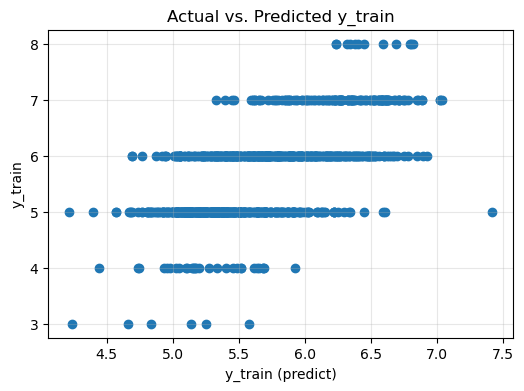

In [280]:
plt.figure(figsize=(6,4))
plt.scatter(y_train_pred, y_train)
plt.xlabel("y_train (predict)")
plt.ylabel("y_train")
plt.title("Actual vs. Predicted y_train")
plt.grid(alpha=0.3)
plt.show()

**Interpretation**: This plot roughly follows a 45-degree line which means that the predictions are mostly aligned with actual targets. However, the spread between predicted and actual values shows that there may still be minor discrepencies in model's learning of the dataset.

**4(e): Root Mean Squares**

In [281]:
def rmse(y_true, y_pred):
    MSE = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(MSE)

In [282]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

rmse_train = rmse(y_train, y_train_pred)
rmse_test = rmse(y_test, y_test_pred)

print("-"*10, "Root-Mean-Squares", "-"*10)
print(f"Train: {rmse_train:.3f}")
print(f"Test: {rmse_test:.3f}")

---------- Root-Mean-Squares ----------
Train: 0.970
Test: 0.854


**4(f): Least-mean-squares (LMS)**

In [283]:
class LeastMeanSquares:
    def __init__(self, stepsize=0.001, iters=500, add_bias=True):
        self.stepsize = stepsize
        self.iters = iters
        self.add_bias = add_bias
        self.betas = None
        self.losses = []
    
    def fit(self, X, y):
        if self.add_bias:
            X = concat_ones(X)
        
        y = np.ravel(y)
        self.betas = np.random.randn(X.shape[1]) # random initialization of w^0, shape = (n_features, 1)

        for _ in range(self.iters):
            for i in range(len(X)): # iterate through each sample
                xi = X[i,:]
                yi = y[i]
                yi_pred = np.dot(xi, self.betas)
                error = yi - yi_pred
                gradient = xi * error
                self.betas += self.stepsize * gradient # update rule (gradient descent)

            y_pred = X @ self.betas
            mse = np.mean((y - y_pred) ** 2)
            self.losses.append(mse)

    def predict(self, X):
        if self.betas is None:
            raise ValueError("Fit function first using 'fit()")
        if self.add_bias:
            X = concat_ones(X)
        return X @ self.betas # (n_samples, n_features) x (n_features, 1)

In [286]:
model = LeastMeanSquares(stepsize=0.0001, iters=500)
model.fit(X_train, y_train)

In [287]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

rmse_train = rmse(np.ravel(y_train), y_train_pred)
rmse_test = rmse(np.ravel(y_test), y_test_pred)

print("-"*10, "Root-Mean-Squares", "-"*10)
print(f"Train: {rmse_train:.3f}")
print(f"Test: {rmse_test:.3f}")

---------- Root-Mean-Squares ----------
Train: 0.700
Test: 0.687


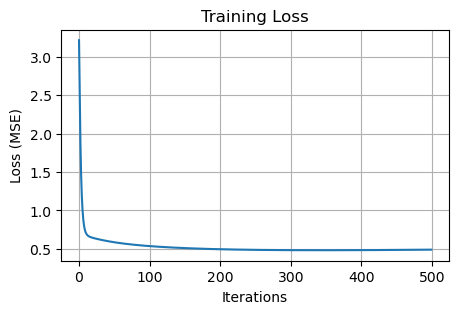

In [288]:
plt.figure(figsize=(5,3))
plt.plot(model.losses)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()